## High-z galaxies with Te measurements

# Determine metallicities using the direct method

In [1]:
## Global stuff
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table

## colors and markers
colors = plt.get_cmap('cubehelix')(np.linspace(0.1, 0.8, 21))
markers = ('>','+','v','D','H','+','s','o','<','X','p','*','^','d','h','x','8','>','+','v','D','H')

## Lines to be used
line_names = ['OIII1661','OIII1666','NIII1750','CIII1907','CIII1909','NeIII3869','OII3727','OII3729','OIITot',
              'Hd','Hg','OIII4363','Hb','OIII4959','OIII5007','Ha','NII6584']

#Probably there is a smart way of doing this with PyNeb
super_wav = {
    'OIII1661': 1661,
    'OIII1666': 1666,
    'NIII1750': 1750,
    'CIII1907': 1907,
    'CIII1909': 1909,
    'NeIII3869': 3869,
    'OII3727': 3727,
    'OII3729': 3729,
    'OIITot': 3729,
    'Hd': 4102,
    'Hg': 4340,
    'OIII4363': 4363,
    'Hb': 4861,
    'OIII4959': 4959,
    'OIII5007': 5007,
    'Ha': 6563,
    'NII6584': 6584
    }

# Quick look at all fluxes

In [2]:
# Load data
fluxes = Table.read('../Data/direct_Te_data.dat',format='ascii.fixed_width_two_line')
fluxes.show_in_notebook()

idx,Name,z,Ref,OIII1661,OIII1666,NIII1750,CIII1907,CIII1909,NeIII3869,OII3727,OII3729,OIITot,Hd,Hg,OIII4363,Hb,OIII4959,OIII5007,Ha,NII6584,eOIII1661,eOIII1666,eNIII1750,eCIII1907,eCIII1909,eNeIII3869,eOII3727,eOII3729,eOIITot,eHd,eHg,eOIII4363,eHb,eOIII4959,eOIII5007,eHa,eNII6584
0,COSMOS_12805,2.159,Kojima2017,0.049,0.075,0.042,nan,nan,nan,nan,nan,2.9,nan,nan,nan,1.0,1.89,6.46,2.84,0.1,0.012,0.015,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.3,0.42,0.29,0.05,nan
1,SMACS_0304,1.963,"Christensen2012a,b",0.014,0.023,nan,nan,nan,0.2998,0.8756,1.1744,2.1,0.257,0.412,nan,1.0,1.339,4.714,3.604,0.116,0.003,0.004,nan,nan,nan,3.8,3.4,3.9,0.02,0.005,0.003,nan,0.002,0.004,0.007,0.001,0.005
2,BX74,2.189,Erb2016,0.0,0.12,nan,nan,nan,nan,nan,nan,1.01,nan,nan,nan,1.0,2.47,7.9,3.46,0.12,0.0,0.01,nan,nan,nan,nan,nan,nan,0.04,nan,nan,nan,nan,1.52,1.0,0.25,0.03
3,BX418,2.305,Erb2016,0.0,0.14,nan,nan,nan,nan,nan,nan,0.9,nan,nan,nan,1.0,2.3,6.4,2.81,0.15,0.0,0.04,nan,nan,nan,nan,nan,nan,0.03,nan,nan,nan,nan,0.7,0.3,0.2,0.03
4,BX660,2.174,Erb2016,0.0,0.21,nan,nan,nan,nan,nan,nan,0.87,nan,nan,nan,1.0,3.2,6.4,2.77,0.07,0.0,0.04,nan,nan,nan,nan,nan,nan,0.04,nan,nan,nan,nan,0.8,0.3,0.2,nan
5,Abell_22.3,1.703,Yuan2009,nan,nan,nan,nan,nan,nan,nan,nan,1.11,nan,nan,0.27,1.0,1.98,6.45,5.03,0.05,nan,nan,nan,nan,nan,nan,nan,nan,0.3,nan,nan,0.1,0.1,0.3,0.3,0.4,nan
6,SGAS_1050,3.625,Bayliss2014,0.018,0.051,0.014,0.199649737303,0.120840630473,0.320490367776,0.395796847636,0.388791593695,0.79,nan,0.52,0.014,1.0,2.35,8.08,nan,nan,0.007,0.007,0.005,0.07,0.08,0.04,0.06,0.06,0.02,nan,0.02,nan,0.01,0.02,0.02,nan,nan
7,CSWA20,1.433,James2014,0.04,0.1,nan,0.12,0.11,0.37,0.47,0.52,0.47,nan,0.57,0.05,1.0,1.67,4.97,3.32,0.06,0.04,0.04,nan,0.01,0.01,0.02,0.02,0.03,0.2,nan,0.05,0.03,0.07,0.1,0.29,0.2,0.02
8,MACS_0451,2.06,Stark2014,0.2,0.3,0.1,nan,nan,nan,nan,nan,0.63,nan,nan,nan,1.0,1.37,3.95,2.58,0.065,0.1,0.1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.1,0.05,0.05,0.16,nan
9,Abell_860_359,1.702,Stark2014,0.03,0.083,0.03,nan,nan,nan,nan,nan,1.2,nan,nan,nan,1.0,2.03,6.12,2.97,nan,nan,0.029,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.03,0.03,0.1,0.03,nan


## Using HII-CHI-mistry
From the website:
>These files represent the whole set of models, limiting the values of log U at each Z (left picture), and limiting also the values of N/O, respectively (right picture).
All were calculated with Cloudy v.13 and a POPSTAR SED at an age of 1Myr with an IMF of Chabrier.


HII-CHI-mistry has two codes: one for UV and other for optical, which means may be a problem:

Optical:
    * [OII] 3727/Hbeta
    * [OIII] 4363/Hbeta
    * [OIII] 5007/Hbeta
    * [NII] 6584/Hbeta
    * [SII] 6717+6731/Hbeta

UV:
    * Lya HI 1216
    * CIV    1549
    * OIII]  1665
    * CIII   1909
    * Hb HI  4861
    * [OIII] 5007


In [2]:
## Save files in the HII-CHI-mistry format: text file with 5 columns with extinction corrected fluxes
def err_ratio(x,y,e_x,e_y):
    """ Formal Error of x/y """
    return x/y * np.sqrt((e_x/x)**2 + (e_y/y)**2)

dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

for gal in dered_fluxes:
    #UV
    f = open('CHImistry/'+gal['Name']+'_UV.dat','w')
    f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
            # Lya   CIV   OIII]                                                             CIII  Hb
            (0.,0.,0.,0.,gal['OIII1661']+gal['OIII1666'],gal['eOIII1661']+gal['eOIII1666'],0.,0.,gal['Hb'],gal['eHb'],
            #[OIII]5007
             gal['OIII5007'],gal['eOIII5007']))
    f.close()        
    # Optical
    f = open('CHImistry/'+gal['Name']+'_Optical.dat','w')
    f.write('%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f\t%0.2f'%
             #[OII] 3727/Hbeta  
             (gal['OII3727']/gal['Hb'],err_ratio(gal['OII3727'],gal['Hb'],gal['eOII3727'],gal['eHb']),
             # [OIII] 4363/Hbeta 
             gal['OIII4363']/gal['Hb'],err_ratio(gal['OIII4363'],gal['Hb'],gal['eOIII4363'],gal['eHb']),
             # [OIII] 5007/Hbeta    
             gal['OIII5007']/gal['Hb'],err_ratio(gal['OIII5007'],gal['Hb'],gal['eOIII5007'],gal['eHb']),                                  
             # [NII] 6584/Hbeta  
             gal['NII6584']/gal['Hb'],err_ratio(gal['NII6584'],gal['Hb'],gal['eNII6584'],gal['eHb']),                                    
             # [SII] 6717+6731/Hbeta
             0.0,0.0))
    f.close()   

In [3]:
## For optical lines
import glob
from HCm_v3_less_verbose import HII_CHIm

MetOH = []
eMetOH = []
MetNO = []
eMetNO =[]
U = []
eU = []

for inputfile in glob.glob('CHImistry/*_Optical.dat'):
    iMetOH,ieMetOH,iMetNO,ieMetNO,iU,ieU = HII_CHIm(0,inputfile,inputfile.replace('.dat','_out'))
    MetOH.append(iMetOH)
    eMetOH.append(ieMetOH)
    MetNO.append(iMetNO)
    eMetNO.append(iMetNO)
    U.append(iU)
    eU.append(ieU)

---------------------------------------------------------------------
Reading file CHImistry/A1689_31.1_Optical.dat
No interpolation for the models are going to be used.
The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.484 0.114  -10.0 0.0  -1.929 0.001
---------------------------------------------------------------------
Reading file CHImistry/Abell_22.3_Optical.dat
No interpolation for the models are going to be used.
The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(N/O)    log(U)
-----------------------------------------------------------------
50.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
100.0 % 1  7.693 0.315  -10.0 0.0  -2.119 0.142
------

In [4]:
## Save results
HCm_out = Table([dered_fluxes['Name'],MetOH,eMetOH,MetNO,eMetNO,U,eU],
                names = ['Name','12+log(O/H)','err_OH','12+log(N/O)','err_NO','U','errU'])
HCm_out.write('HCm_Optical.dat',format='ascii.fixed_width_two_line')
HCm_out.show_in_notebook()      

idx,Name,12+log(O/H),err_OH,12+log(N/O),err_NO,U,errU
0,COSMOS_12805,7.484,0.114,-10.0,-10.0,-1.929,0.001
1,SMACS_0304,7.693,0.315,-10.0,-10.0,-2.119,0.142
2,BX74,0.0,0.0,-10.0,-10.0,0.0,0.0
3,BX418,8.2,0.022,-10.0,-10.0,-2.517,0.003
4,BX660,8.08,0.023,-10.0,-10.0,-2.315,0.011
5,Abell_22.3,8.141,0.033,-10.0,-10.0,-2.476,0.004
6,SGAS_1050,7.982,0.205,-10.0,-10.0,-1.996,0.163
7,CSWA20,8.132,0.053,-10.0,-10.0,-2.475,0.144
8,MACS_0451,8.141,0.338,-1.18,-1.18,-2.308,0.235
9,Abell_860_359,8.022,0.045,-10.0,-10.0,-2.66,0.062


<IPython.core.display.Javascript object>


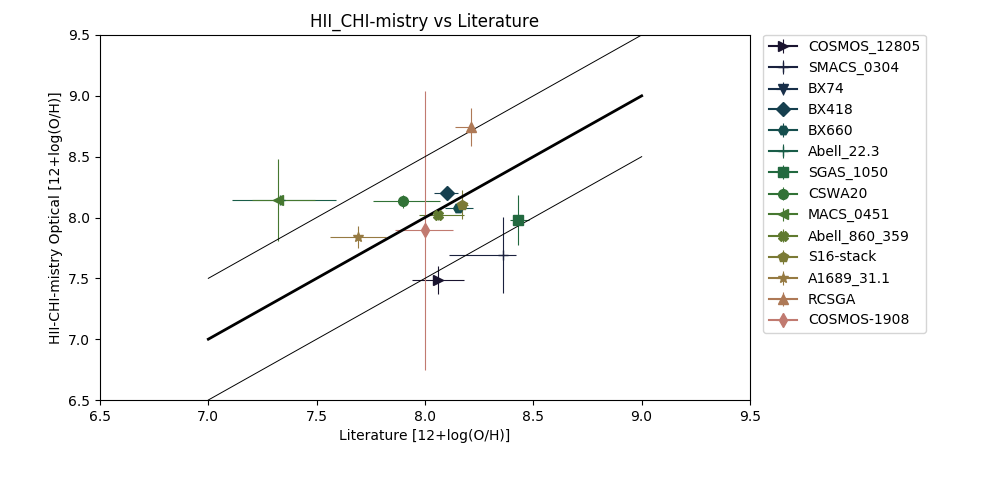

In [8]:
# Compare with previous estimations
properties = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
properties.remove_row(12)

fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.75,left=0.1)
for i,gal in enumerate(properties):    
    ax.errorbar(gal['MetTe'],MetOH[i],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),yerr=eMetOH[i],
                label=gal['Name'],marker=markers[i],color=colors[i],markersize=7,elinewidth=0.8)

ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
ax.set_ylabel('HII-CHI-mistry Optical [12+log(O/H)]')
ax.set_xlabel('Literature [12+log(O/H)]')
ax.set_ylim(6.5,9.5)
ax.set_xlim(6.5,9.5)
ax.set_title('HII_CHI-mistry vs Literature')
plt.legend(bbox_to_anchor=(1.01, 1.02))

In [9]:
# With the UV lines
import glob
from HCm_UV_v3_less_verbose import HII_CHIm_UV

MetOH_UV = []
eMetOH_UV = []
MetCO_UV = []
eMetCO_UV =[]
U_UV = []
eU_UV = []

for inputfile in glob.glob('CHImistry/*_UV.dat'):
    try:
        iMetOH,ieMetOH,iMetCO,ieMetCO,iU,ieU = HII_CHIm_UV(inputfile,inputfile.replace('.dat','_out.dat'))
        MetOH_UV.append(iMetOH)
        eMetOH_UV.append(ieMetOH)
        MetCO_UV.append(iMetCO)
        eMetCO_UV.append(iMetCO)
        U_UV.append(iU)
        eU_UV.append(ieU)
    except ZeroDivisionError:
        print('Bad Input File? Not abble to estimate something?')
        MetOH_UV.append(np.nan)
        eMetOH_UV.append(np.nan)
        MetCO_UV.append(np.nan)
        eMetCO_UV.append(np.nan)
        U_UV.append(np.nan)
        eU_UV.append(np.nan)
    print(inputfile,iMetOH,ieMetOH)

---------------------------------------------------------------------
Reading file CHImistry/A1689_31.1_UV.dat

The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(C/O)    log(U)
-----------------------------------------------------------------
50.0 % 1  7.205 0.049  -10.0 0.0  -1.702 0.054
100.0 % 3  0.0 0.0  -10.0 0.0  0.0 0.0
('CHImistry/A1689_31.1_UV.dat', 0.0, 0.0)
---------------------------------------------------------------------
Reading file CHImistry/Abell_22.3_UV.dat

The grid has a resolution of 0.1dex for O/H and 0.125dex for N/O

----------------------------------------------------------------
(%)   Grid  12+log(O/H)  log(C/O)    log(U)
-----------------------------------------------------------------
Bad Input File? Not abble to estimate something?
('CHImistry/Abell_22.3_UV.dat', 0.0, 0.0)
---------------------------------------------------------------------
Readi

Not working or not enough lines

## Using IRAF

In [12]:
## Temperatures from Isotov 2009
def Isotov06_TOIII(f,t):
    """ Equation 1 of Isotov 2006. Only works if OIII4663 is seen. Neglecting density.
    """
    t *= 1e-4
    CT = 8.44 - 1.09*t + 0.5*t**2 - 0.08*t**3 # Here we are neglecting the density
    new_t = 1.432 /(np.log10((f['OIII4959'] + f['OIII5007'])/f['OIII4363']) - np.log10(CT))
    return new_t * 1e4

def calculate_TOIII(f):
    
    params = Parameters()
    params.add('t', value=10000., min=1000., max=30000.)
    
    def fnc(params,f):
        t = params['t']
        return t - Isotov06_TOIII(f,t)
    
    fit = minimize(fnc, params,args=(f,),method='least_squares')
    
    return fit.params['t'].value
    
    
def Isotov06_TOII(tOIII,Z='intermediate'):
    """Equation 14 of Isotov 2006. The dispersion of this relation is not provided
    """
    tOIII *= 1e-4 
    if Z == 'low': # 7.2
        return (-0.577 + tOIII * (2.065 - 0.498*tOIII))*1e4 
    elif Z == 'intermediate': #7.6
         return (-0.744 + tOIII * (2.338 - 0.610*tOIII))*1e4 
    elif Z == 'high': # 8.2
        return (2.967 + tOIII * (-4.797 + 2.827*tOIII))*1e4 
    else:
        print('Wrong "Z" option')

In [13]:
# Calculate metallicities
import pyneb as pn
pn.atomicData.setDataFile('o_iii_coll_AK99.dat') # have to change because the default ones do not have level 6
O3 = pn.Atom('O', 3)
O2 = pn.Atom('O',2)

dered_fluxes = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []

def sum_met(OH,O2H):
    return 12 + np.log10(10**(OH-12)+10**(O2H-12))

print('                Name\tO/H\tO+2/H\tMetOH')
for f in dered_fluxes:
    
    #  Calculate TOII. take our estimated temperatures as TOIII.
    t = (Isotov06_TOII(f['Te'],Z='intermediate')) # May need to change the Z
    
    def change_scale(x):
        return 12+np.log10(x)
    
    # Calculate metalliticites
    O2_H_pyneb.append(change_scale(O3.getIonAbundance((f['OIII4959']+f['OIII5007']),f['Te'],f['Den'],
                                                to_eval='L(4959)+L(5007)',Hbeta=f['Hb'])))
    O_H_pyneb.append(change_scale(O2.getIonAbundance((f['OIITot']),t,f['Den'],
                                                     to_eval='L(3726)+L(3729)',Hbeta=f['Hb'])))
    met_pyneb.append(sum_met(O2_H_pyneb[-1],O_H_pyneb[-1]))
    
    print('%20s\t%0.2f\t%0.2f\t%0.2f'%(f['Name'],O_H_pyneb[-1],O2_H_pyneb[-1],met_pyneb[-1]))


                Name	O/H	O+2/H	MetOH
        COSMOS_12805	7.49	7.82	7.99
          SMACS_0304	nan	nan	nan
                BX74	7.20	8.13	8.18
               BX418	7.12	7.96	8.02
               BX660	7.24	8.16	8.21
          Abell_22.3	7.77	8.21	8.35
           SGAS_1050	7.00	8.03	8.07
              CSWA20	6.63	7.41	7.48
           MACS_0451	7.08	7.91	7.97
       Abell_860_359	7.29	7.35	7.62
           S16-stack	7.63	7.86	8.06
          A1689_31.1	7.00	7.90	7.95
           USD-12539	7.86	nan	nan
               RCSGA	7.38	7.49	7.74
         COSMOS-1908	7.03	8.21	8.24


# How to get an error using Pyned? 

Using MC? 

    1) Draw an E(B-V)
    2) Dered the lines
    3) Draw a temperature and a density
    4) Calculate the metalllicity

repeat for a couple of times?

In [14]:
# Calculate metallicities with error estimation
from astropy.visualization import hist
import pickle
galaxies = Table.read('direct_Te_data_dered.dat',format='ascii.fixed_width_two_line')

O_H_pyneb = []
O2_H_pyneb = []
met_pyneb = []
upO_H_pyneb = []
upO2_H_pyneb = []
upmet_pyneb = []
lowO_H_pyneb = []
lowO2_H_pyneb = []
lowmet_pyneb = []

def change_scale(x):
    return 12+np.log10(x)

print('                Name\t       O/H\t\t       O+2/H\t\t      MetOH')
for gal in galaxies:
    
    # Open flux files
    dered_f = pickle.load( open( 'dered_f_samples/'+gal['Name']+"_flux_samples.pickle", "rb" ) )
    O2_H_sample = []
    O_H_sample = []
    
    #  Sample of densitties and TOIII. Calculate TOII
    tem_and_den    = pickle.load( open( 'tem_and_ebv_samples/'+gal['Name']+"_tem_and_ebv.pickle", "rb" ) )
    tOIII_sample  = np.random.choice(tem_and_den['tem'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Te'])
    den_sample    = np.random.choice(tem_and_den['den'], len(dered_f['Hb']))#np.full_like(dered_f['Hb'],gal['Den'])  
    tOII_sample   = np.array([Isotov06_TOII(x,Z='intermediate') for x in tOIII_sample]) # May need to change the Z

    ## Calculate metalliticites
    O2_H_sample.append(O3.getIonAbundance(np.array(dered_f['OIII4959'])+np.array(dered_f['OIII5007']),
                                          tOIII_sample,den_sample,to_eval='L(4959)+L(5007)',Hbeta=dered_f['Hb']))
    O_H_sample.append(O2.getIonAbundance(np.array(dered_f['OIITot']),
                                          tOII_sample,den_sample,
                                          to_eval='L(3726)+L(3729)',Hbeta=dered_f['Hb']))

    total = np.array([change_scale(m1+m2) for  m1,m2 in zip(O2_H_sample,O_H_sample)])
    O2_H_sample = np.array([change_scale(m) for  m in O2_H_sample])
    O_H_sample  = np.array([change_scale(m) for  m in O_H_sample])
    
    O2_H_pyneb.append(np.percentile(O2_H_sample,50))
    O_H_pyneb.append(np.percentile(O_H_sample,50)) 
    upO2_H_pyneb.append(np.percentile(O2_H_sample,84)-np.percentile(O2_H_sample,50))
    upO_H_pyneb.append(np.percentile(O_H_sample,84)-np.percentile(O_H_sample,50))
    lowO2_H_pyneb.append(np.percentile(O2_H_sample,50)-np.percentile(O2_H_sample,16))
    lowO_H_pyneb.append(np.percentile(O_H_sample,50)-np.percentile(O_H_sample,16))
    met_pyneb.append(np.percentile(total,50))
    upmet_pyneb.append(np.percentile(total,84)-np.percentile(total,50))
    lowmet_pyneb.append(np.percentile(total,50)-np.percentile(total,16))

    
    print('%20s\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f\t%0.2f + %0.2f - %0.2f'%(gal['Name'],
                                                               O_H_pyneb[-1],upO_H_pyneb[-1],lowO_H_pyneb[-1],
                                                               O2_H_pyneb[-1],upO2_H_pyneb[-1],lowO2_H_pyneb[-1],
                                                               met_pyneb[-1],upmet_pyneb[-1],lowmet_pyneb[-1]))


                Name	       O/H		       O+2/H		      MetOH
        COSMOS_12805	7.75 + 0.31 - 0.26	8.10 + 0.21 - 0.27	8.26 + 0.23 - 0.25
          SMACS_0304	7.89 + 0.22 - 0.10	8.07 + 0.06 - 0.05	8.30 + 0.11 - 0.06
                BX74	7.20 + 0.04 - 0.04	8.13 + 0.04 - 0.04	8.18 + 0.04 - 0.04
               BX418	7.05 + 0.09 - 0.06	7.95 + 0.10 - 0.07	8.00 + 0.10 - 0.07
               BX660	6.95 + 0.04 - 0.03	7.88 + 0.05 - 0.05	7.93 + 0.05 - 0.04
          Abell_22.3	nan + nan - nan	nan + nan - nan	nan + nan - nan
           SGAS_1050	7.56 + 0.13 - 0.12	8.54 + 0.06 - 0.08	8.58 + 0.07 - 0.08
              CSWA20	7.01 + 0.43 - 0.23	8.08 + 0.30 - 0.21	8.12 + 0.31 - 0.21
           MACS_0451	6.73 + 0.11 - 0.07	7.44 + 0.18 - 0.16	7.52 + 0.16 - 0.12
       Abell_860_359	7.29 + 0.14 - 0.09	8.01 + 0.13 - 0.09	8.08 + 0.13 - 0.08
           S16-stack	7.75 + 0.04 - 0.05	7.94 + 0.04 - 0.04	8.16 + 0.04 - 0.05
          A1689_31.1	6.84 + 0.21 - 0.19	7.39 + 0.16 - 0.13	7.50 + 0.12 - 0.07
           USD

<IPython.core.display.Javascript object>


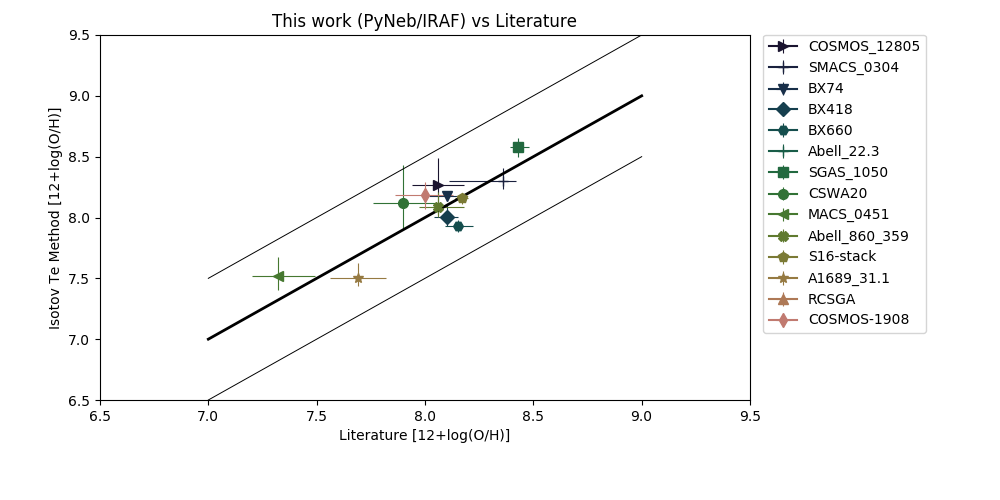

In [17]:
# Compare with previous estimations
properties = Table.read('../Data/galaxy_properties.dat',format='ascii.fixed_width_two_line')
properties.remove_row(12)

fig, ax = plt.subplots(1,1,figsize=(10,5))
fig.subplots_adjust(top=0.93,bottom=0.2,right=0.75,left=0.1)
for i,gal in enumerate(properties):    
    ax.errorbar(gal['MetTe'],met_pyneb[i],
                xerr=np.array((np.abs(gal['infMetTe']),gal['supMetTe'])).reshape(2,1),
                yerr=np.array((lowmet_pyneb[i],upmet_pyneb[i])).reshape(2,1),
                label=gal['Name'],marker=markers[i],color=colors[i],markersize=7,elinewidth=0.8)

ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5),color='k',linewidth=2.0)
ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)+0.5,color='k',linewidth=0.7)
ax.plot(np.arange(7.0,9.5),np.arange(7.0,9.5)-0.5,color='k',linewidth=0.7)
ax.set_ylabel('Isotov Te Method [12+log(O/H)]')
ax.set_xlabel('Literature [12+log(O/H)]')
ax.set_ylim(6.5,9.5)
ax.set_xlim(6.5,9.5)
ax.set_title('This work (PyNeb/IRAF) vs Literature')
plt.legend(bbox_to_anchor=(1.01, 1.02))

In [15]:
## Save results
pyneb_out = Table([dered_fluxes['Name'],O_H_pyneb,O2_H_pyneb,met_pyneb],
                names = ['Name','12+log(O+/H)','12+log(O2+/H)','12+log(O/H)'])
pyneb_out.write('Pyneb_Te_method.dat',format='ascii.fixed_width_two_line')
pyneb_out.show_in_notebook() 

idx,Name,12+log(O+/H),12+log(O2+/H),12+log(O/H)
0,COSMOS_12805,7.49419893157,7.8171324504,7.98604458294
1,SMACS_0304,nan,nan,nan
2,BX74,7.20096189436,8.12865752289,8.17714392452
3,BX418,7.12092948959,7.95782505821,8.01685082634
4,BX660,7.24377181089,8.16303334612,8.21241848098
5,Abell_22.3,7.77461260489,8.21499102895,8.34941098756
6,SGAS_1050,7.0004055963,8.03282416393,8.07136769144
7,CSWA20,6.62639173991,7.41452361357,7.48005856608
8,MACS_0451,7.07652718896,7.9138041367,7.97278145758
9,Abell_860_359,7.2930500535,7.34796251063,7.62240359575


## Following Isotov 2006

In [16]:
from lmfit import minimize, Parameters
        
def Isotov09_O_H(f,t):
    """Equation 3 of Isotov 2009. Temperature is T OII.
    Not including density term.
    """
    t *= 1e-4 
    if np.isfinite(f['OII3727']):
        return np.log10((f['OII3727']+f['OII3729'])/f['Hb']) + 5.961 + 1.676/t - 0.40*np.log10(t) - 0.034*t+np.log10(1)
    else:
        return np.log10(f['OIITot']/f['Hb']) + 5.961 + 1.676/t - 0.40*np.log10(t) - 0.034*t + np.log10(1)

def Isotov09_O2_H(f,t):
    """Equation 5 of Isotov 2009. Temperature is T OIII.
    """
    t *= 1e-4 
    return np.log10((f['OIII4959']+f['OIII5007'])/f['Hb']) + 6.200 + 1.251*t -0.55*np.log10(t) - 0.014*t

def Isotov09_Ne2_H(f,t):
    """Equation 7 of Isotov 2009. Temperature is T OIII.
    """
    t *= 1e-4 
    return np.log10(f['NeIII3869']/f['Hb'])+ 6.444 + 1.606*t -0.42*np.log10(t) - 0.009*t